In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

c:\Users\Zephyrus\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zephyrus\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\Zephyrus\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:

# Database connection parameters
db_params = {
    'dbname': 'integration',
    'user': 'postgres',
    'password': '1234',
    'host': 'localhost',
    'port': '5432'
}


In [3]:
# Establishing the connection
conn = psycopg2.connect(**db_params)

# Define your SQL query
query = "SELECT * FROM db_events;"

# Execute the query and store the result in a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the DataFrame
print(df.head())

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_13068\3958174467.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


   duracion       fecha  hora  esquema                tabla  \
0        38  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
1        42  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
2        27  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
3        15  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
4        21  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   

                                    app  Day of month  ID Day of week  \
0  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
1  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
2  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
3  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
4  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   

  Day of week    mean_st  ...  rango_final_by_table  tamañano_resp_by_table  \
0      sábado  28.165406  ...          7.980910e+07            2.439692e+06   
1      sábado  28.165406

In [4]:
d_row = df[df['pre_clasificacion'] == 'NORMAL']

# Randomly select 50% of those rows
np.random.seed(0)  # For reproducibility
sample_rows_d = d_row.sample(frac=1) #0.7

# Drop the selected rows from the original DataFrame
df = df.drop(sample_rows_d.index)

In [5]:
df_filtered = df[df['duracion'] <= 70]

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

selected_cols = df_filtered[['tabla', 'app', 'Day of month',
       'ID Day of week', 'mean_st', 'std_st', 'min', 'max',
       'rango_inicial_by_table', 'rango_final_by_table',
       'tamañano_resp_by_table',
       'Evento del Dia',  'latencia_by_day_month',
       'latencia_by_day_week', 'SimultJobs','duracion']]

categorical_columns = ['tabla','app','Evento del Dia']
numeric_columns = ['ID Day of week','min','max','SimultJobs','Day of month','rango_inicial_by_table','rango_final_by_table'
                   ,'tamañano_resp_by_table','latencia_by_day_month','latencia_by_day_week','mean_st', 'std_st']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])


encoded_data = preprocessor.fit_transform(selected_cols)

X = encoded_data
y = selected_cols['duracion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten,Dropout
from tensorflow.keras.optimizers import Adam

In [8]:
input_shape = X_train.shape[1]

input_layer = Input(shape=(input_shape,))
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
output_layer = Dense(1)(x)

In [9]:
model = Model(inputs=input_layer, outputs=output_layer)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

In [11]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
17279/17279 [==============================] - 41s 2ms/step - loss: 106.1646 - mean_absolute_error: 7.5788 - val_loss: 139.1598 - val_mean_absolute_error: 8.8709
Epoch 2/20
17279/17279 [==============================] - 45s 3ms/step - loss: 65.9378 - mean_absolute_error: 6.1999 - val_loss: 93.0491 - val_mean_absolute_error: 6.5504
Epoch 3/20
17279/17279 [==============================] - 40s 2ms/step - loss: 63.0201 - mean_absolute_error: 6.0719 - val_loss: 79.3508 - val_mean_absolute_error: 6.0028
Epoch 4/20
17279/17279 [==============================] - 39s 2ms/step - loss: 61.9789 - mean_absolute_error: 6.0167 - val_loss: 67.1976 - val_mean_absolute_error: 5.6703
Epoch 5/20
17279/17279 [==============================] - 41s 2ms/step - loss: 61.1132 - mean_absolute_error: 5.9729 - val_loss: 65.3741 - val_mean_absolute_error: 5.6216
Epoch 6/20
17279/17279 [==============================] - 40s 2ms/step - loss: 60.8811 - mean_absolute_error: 5.9608 - val_loss: 64.5802 - val_

In [12]:
y_test

315997     41
462905     40
1084591    68
2805109    49
3376625    38
           ..
412298     44
2434479    41
2954775    34
3158609    41
2401702    53
Name: duracion, Length: 236970, dtype: int64

In [13]:
predictions = model.predict(X_test)

In [14]:
preds_reg = []
for i in predictions:
    preds_reg.append(i[0])

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate the model
mse = mean_squared_error(y_test, preds_reg)
r2 = r2_score(y_test, preds_reg)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 68.25
R-squared: 0.30


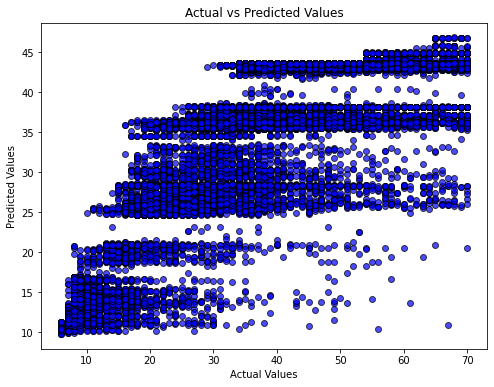

In [16]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds_reg, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [17]:
model.save('cnn_reg.h5')